In [2]:
from AutoEncoder import myAutoEncoder
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Load Data

In [3]:
df = pd.read_csv('/Users/bowen/Desktop/H/deeplearninveststrat/Data/100_clean.csv')
df = df.drop('Unnamed: 0', axis=1)
df['Date'] = pd.to_datetime(df['Date'])

In [4]:
featureList = ['Revenue', 'Cost of Goods Sold', 'SG&A','EBIT', 'Net Income', 
               'Cash and Cash Equivalents', 'Recievables','Inventories', 'Other Current Assets', 
               'PP&E', 'Other Assets', 'Debt in Current Liabilities', 'Accounts Payable', 'Taxes Payable',
               'Other Current Liabilities', 'Total Liabilities']
quarterlyData = {}
dfgb = df.groupby('gvkey')
for gvkey, data in dfgb:
    if len(data) == 115:
        quarterlyData[gvkey] = data.iloc[:114][featureList]

## Denoising with AutoEncoder

In [5]:
def Run(Data):
    n_input = 16
    n_hidden_1 = 11
    n_hidden_2 = 4
    
    AutoEncoder = myAutoEncoder(n_input, n_hidden_1, n_hidden_2)
    X_train, trainDataWithNoise, testData = AutoEncoder.NormalizedStockData(Data)
    
    batch_size = 6
    learning_rate = 0.05
    training_epochs = 150

    X = tf.placeholder("float", [batch_size, n_input])
    y_true = tf.placeholder("float", [batch_size, n_input])
    encoder_op = AutoEncoder.encoder(X)
    decoder_op = AutoEncoder.decoder(encoder_op)
    y_pred = decoder_op
    cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

    with tf.Session() as sess:
        init = tf.global_variables_initializer()
        sess.run(init)

        for epoch in range(training_epochs):
            row = 0
            for i in range(int(trainDataWithNoise.shape[0] / batch_size)):
                batch_xs = trainDataWithNoise[row:row + batch_size]
                y_xs = X_train[row:row + batch_size]
                row += batch_size
                _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs, y_true:y_xs })
            print("Epoch:", '%04d' % (epoch + 1), "cost =", "{:.9f}".format(c))
        print("Optimization Finished!")

        result = []
        row = 0
        for i in range(int(testData.shape[0] / batch_size)):
            batch_xs = testData[row:row + batch_size]
            row += batch_size
            res = sess.run(decoder_op, feed_dict={X: batch_xs})
            result.extend(res.tolist())
    return result


def transToDataFrame(result, gvkey, df):
    r = pd.DataFrame(result)
    r.columns = ['Revenue', 'Cost of Goods Sold', 'SG&A','EBIT', 'Net Income', 
               'Cash and Cash Equivalents', 'Recievables','Inventories', 'Other Current Assets', 
               'PP&E', 'Other Assets', 'Debt in Current Liabilities', 'Accounts Payable', 'Taxes Payable',
               'Other Current Liabilities', 'Total Liabilities']
    
    r['timestemp'] = df[df['gvkey'] == gvkey][:-1]['Date'].values
    r['EBIT/EV'] = df[df['gvkey'] == gvkey][:-1]['EBIT/EV'].values
    return r

## test for single stock

In [6]:
data = quarterlyData[1209]

In [7]:
n_input = 16
n_hidden_1 = 11
n_hidden_2 = 4
AutoEncoder = myAutoEncoder(n_input, n_hidden_1, n_hidden_2)
X_train, trainDataWithNoise, testData = AutoEncoder.NormalizedStockData(data)

In [8]:
result = Run(data)

Epoch: 0001 cost = 0.252771258
Epoch: 0002 cost = 0.235838816
Epoch: 0003 cost = 0.219568059
Epoch: 0004 cost = 0.191749990
Epoch: 0005 cost = 0.187146947
Epoch: 0006 cost = 0.179175913
Epoch: 0007 cost = 0.163916066
Epoch: 0008 cost = 0.146897376
Epoch: 0009 cost = 0.127316937
Epoch: 0010 cost = 0.106586240
Epoch: 0011 cost = 0.086228929
Epoch: 0012 cost = 0.069031984
Epoch: 0013 cost = 0.057663839
Epoch: 0014 cost = 0.049236845
Epoch: 0015 cost = 0.038139127
Epoch: 0016 cost = 0.038361754
Epoch: 0017 cost = 0.041451070
Epoch: 0018 cost = 0.031109756
Epoch: 0019 cost = 0.031140650
Epoch: 0020 cost = 0.033188492
Epoch: 0021 cost = 0.043593686
Epoch: 0022 cost = 0.025458859
Epoch: 0023 cost = 0.028876415
Epoch: 0024 cost = 0.030064335
Epoch: 0025 cost = 0.025661886
Epoch: 0026 cost = 0.029111907
Epoch: 0027 cost = 0.036571421
Epoch: 0028 cost = 0.031619113
Epoch: 0029 cost = 0.067832470
Epoch: 0030 cost = 0.022579754
Epoch: 0031 cost = 0.068732165
Epoch: 0032 cost = 0.020670930
Epoch: 0

In [9]:
ha = transToDataFrame(result,1209, df)

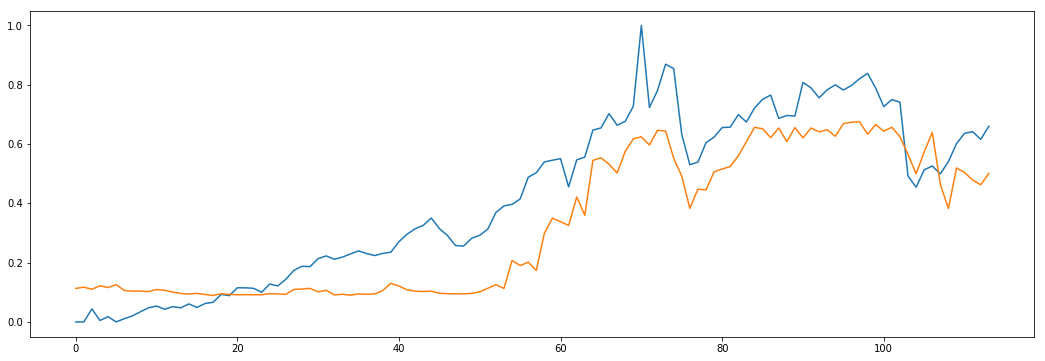

In [10]:
plt.figure(figsize=(18,6))
plt.plot(testData['Revenue'])
plt.plot(ha['Revenue'])

# plt.xlabel('Time')
# plt.ylabel('Rate')
plt.show()

## Denoising all stocks

In [12]:
finalResult = {}
gvkeyList = [i for i in quarterlyData.keys()]
for gvkey in gvkeyList:
    result = Run(quarterlyData[gvkey])
    finalResult[gvkey] = transToDataFrame(result,gvkey, df)

Epoch: 0001 cost = 0.319061071
Epoch: 0002 cost = 0.200001284
Epoch: 0003 cost = 0.174152806
Epoch: 0004 cost = 0.175536826
Epoch: 0005 cost = 0.153797328
Epoch: 0006 cost = 0.127924219
Epoch: 0007 cost = 0.101814330
Epoch: 0008 cost = 0.075673319
Epoch: 0009 cost = 0.059820104
Epoch: 0010 cost = 0.042766374
Epoch: 0011 cost = 0.053617213
Epoch: 0012 cost = 0.051039848
Epoch: 0013 cost = 0.035110362
Epoch: 0014 cost = 0.039224137
Epoch: 0015 cost = 0.076160699
Epoch: 0016 cost = 0.035385024
Epoch: 0017 cost = 0.056917179
Epoch: 0018 cost = 0.035013437
Epoch: 0019 cost = 0.050326530
Epoch: 0020 cost = 0.044275869
Epoch: 0021 cost = 0.048099380
Epoch: 0022 cost = 0.044792045
Epoch: 0023 cost = 0.050683994
Epoch: 0024 cost = 0.039814197
Epoch: 0025 cost = 0.041956346
Epoch: 0026 cost = 0.041566771
Epoch: 0027 cost = 0.042444233
Epoch: 0028 cost = 0.039362013
Epoch: 0029 cost = 0.043555971
Epoch: 0030 cost = 0.038132336
Epoch: 0031 cost = 0.041060746
Epoch: 0032 cost = 0.038200650
Epoch: 0

Epoch: 0123 cost = 0.012176356
Epoch: 0124 cost = 0.012496260
Epoch: 0125 cost = 0.011719865
Epoch: 0126 cost = 0.029157579
Epoch: 0127 cost = 0.012395978
Epoch: 0128 cost = 0.032128748
Epoch: 0129 cost = 0.011820187
Epoch: 0130 cost = 0.012948290
Epoch: 0131 cost = 0.014542428
Epoch: 0132 cost = 0.013625694
Epoch: 0133 cost = 0.013273896
Epoch: 0134 cost = 0.013347884
Epoch: 0135 cost = 0.013142367
Epoch: 0136 cost = 0.013083431
Epoch: 0137 cost = 0.013133396
Epoch: 0138 cost = 0.013092317
Epoch: 0139 cost = 0.013112463
Epoch: 0140 cost = 0.013240349
Epoch: 0141 cost = 0.012842089
Epoch: 0142 cost = 0.013510700
Epoch: 0143 cost = 0.012090057
Epoch: 0144 cost = 0.012911803
Epoch: 0145 cost = 0.012426920
Epoch: 0146 cost = 0.012917685
Epoch: 0147 cost = 0.011833663
Epoch: 0148 cost = 0.013176698
Epoch: 0149 cost = 0.011947669
Epoch: 0150 cost = 0.013636936
Optimization Finished!
Epoch: 0001 cost = 0.445980936
Epoch: 0002 cost = 0.419300228
Epoch: 0003 cost = 0.361850113
Epoch: 0004 cost

Epoch: 0106 cost = 0.014550343
Epoch: 0107 cost = 0.018160949
Epoch: 0108 cost = 0.013644596
Epoch: 0109 cost = 0.020240625
Epoch: 0110 cost = 0.013789252
Epoch: 0111 cost = 0.023920869
Epoch: 0112 cost = 0.014183946
Epoch: 0113 cost = 0.025364449
Epoch: 0114 cost = 0.013782690
Epoch: 0115 cost = 0.021085612
Epoch: 0116 cost = 0.012768310
Epoch: 0117 cost = 0.018705681
Epoch: 0118 cost = 0.012379491
Epoch: 0119 cost = 0.016903492
Epoch: 0120 cost = 0.012494520
Epoch: 0121 cost = 0.019807408
Epoch: 0122 cost = 0.012617315
Epoch: 0123 cost = 0.018625299
Epoch: 0124 cost = 0.013045992
Epoch: 0125 cost = 0.021734772
Epoch: 0126 cost = 0.012430566
Epoch: 0127 cost = 0.018530728
Epoch: 0128 cost = 0.012493295
Epoch: 0129 cost = 0.017386457
Epoch: 0130 cost = 0.011889621
Epoch: 0131 cost = 0.016465237
Epoch: 0132 cost = 0.011970252
Epoch: 0133 cost = 0.017175639
Epoch: 0134 cost = 0.011752424
Epoch: 0135 cost = 0.014822640
Epoch: 0136 cost = 0.011974704
Epoch: 0137 cost = 0.017684393
Epoch: 0

Epoch: 0073 cost = 0.025730347
Epoch: 0074 cost = 0.026147947
Epoch: 0075 cost = 0.024265265
Epoch: 0076 cost = 0.027806921
Epoch: 0077 cost = 0.024830593
Epoch: 0078 cost = 0.026529716
Epoch: 0079 cost = 0.024237201
Epoch: 0080 cost = 0.026773551
Epoch: 0081 cost = 0.023505695
Epoch: 0082 cost = 0.026707128
Epoch: 0083 cost = 0.023409700
Epoch: 0084 cost = 0.026546033
Epoch: 0085 cost = 0.023283249
Epoch: 0086 cost = 0.024760744
Epoch: 0087 cost = 0.022232527
Epoch: 0088 cost = 0.026141459
Epoch: 0089 cost = 0.022585714
Epoch: 0090 cost = 0.023846870
Epoch: 0091 cost = 0.021375477
Epoch: 0092 cost = 0.023504386
Epoch: 0093 cost = 0.020977303
Epoch: 0094 cost = 0.024081258
Epoch: 0095 cost = 0.020500975
Epoch: 0096 cost = 0.025071681
Epoch: 0097 cost = 0.021031169
Epoch: 0098 cost = 0.021086985
Epoch: 0099 cost = 0.019392729
Epoch: 0100 cost = 0.024882605
Epoch: 0101 cost = 0.020794682
Epoch: 0102 cost = 0.021780124
Epoch: 0103 cost = 0.019824052
Epoch: 0104 cost = 0.018760910
Epoch: 0

Epoch: 0049 cost = 0.013628970
Epoch: 0050 cost = 0.010631385
Epoch: 0051 cost = 0.011588767
Epoch: 0052 cost = 0.013203141
Epoch: 0053 cost = 0.009403887
Epoch: 0054 cost = 0.017621556
Epoch: 0055 cost = 0.009961075
Epoch: 0056 cost = 0.009473937
Epoch: 0057 cost = 0.021027187
Epoch: 0058 cost = 0.008913266
Epoch: 0059 cost = 0.011543267
Epoch: 0060 cost = 0.011000709
Epoch: 0061 cost = 0.014754268
Epoch: 0062 cost = 0.009763006
Epoch: 0063 cost = 0.010005310
Epoch: 0064 cost = 0.010711576
Epoch: 0065 cost = 0.010035480
Epoch: 0066 cost = 0.009851440
Epoch: 0067 cost = 0.009734753
Epoch: 0068 cost = 0.009456340
Epoch: 0069 cost = 0.008667664
Epoch: 0070 cost = 0.009602995
Epoch: 0071 cost = 0.009508209
Epoch: 0072 cost = 0.008181217
Epoch: 0073 cost = 0.020319531
Epoch: 0074 cost = 0.007504725
Epoch: 0075 cost = 0.009580486
Epoch: 0076 cost = 0.009797695
Epoch: 0077 cost = 0.010057006
Epoch: 0078 cost = 0.008211394
Epoch: 0079 cost = 0.008639019
Epoch: 0080 cost = 0.008515585
Epoch: 0

Epoch: 0026 cost = 0.037805036
Epoch: 0027 cost = 0.036853399
Epoch: 0028 cost = 0.036666181
Epoch: 0029 cost = 0.035874382
Epoch: 0030 cost = 0.037235070
Epoch: 0031 cost = 0.032646451
Epoch: 0032 cost = 0.042228255
Epoch: 0033 cost = 0.032657489
Epoch: 0034 cost = 0.037907299
Epoch: 0035 cost = 0.033814799
Epoch: 0036 cost = 0.033395022
Epoch: 0037 cost = 0.031026134
Epoch: 0038 cost = 0.031350348
Epoch: 0039 cost = 0.028624928
Epoch: 0040 cost = 0.034761846
Epoch: 0041 cost = 0.027902991
Epoch: 0042 cost = 0.038357869
Epoch: 0043 cost = 0.032676097
Epoch: 0044 cost = 0.033864740
Epoch: 0045 cost = 0.028648818
Epoch: 0046 cost = 0.029207671
Epoch: 0047 cost = 0.026201120
Epoch: 0048 cost = 0.035016064
Epoch: 0049 cost = 0.027243868
Epoch: 0050 cost = 0.034294624
Epoch: 0051 cost = 0.032128889
Epoch: 0052 cost = 0.029185921
Epoch: 0053 cost = 0.028069178
Epoch: 0054 cost = 0.029946193
Epoch: 0055 cost = 0.025460349
Epoch: 0056 cost = 0.026329556
Epoch: 0057 cost = 0.024175376
Epoch: 0

Epoch: 0145 cost = 0.012644209
Epoch: 0146 cost = 0.010776055
Epoch: 0147 cost = 0.012021982
Epoch: 0148 cost = 0.011102722
Epoch: 0149 cost = 0.010885281
Epoch: 0150 cost = 0.011684039
Optimization Finished!
Epoch: 0001 cost = 0.249583259
Epoch: 0002 cost = 0.203366145
Epoch: 0003 cost = 0.186957717
Epoch: 0004 cost = 0.172296226
Epoch: 0005 cost = 0.167512357
Epoch: 0006 cost = 0.149658680
Epoch: 0007 cost = 0.132154718
Epoch: 0008 cost = 0.110605717
Epoch: 0009 cost = 0.085898392
Epoch: 0010 cost = 0.074064173
Epoch: 0011 cost = 0.078468107
Epoch: 0012 cost = 0.107916974
Epoch: 0013 cost = 0.061419528
Epoch: 0014 cost = 0.076617151
Epoch: 0015 cost = 0.066912390
Epoch: 0016 cost = 0.060556274
Epoch: 0017 cost = 0.062915824
Epoch: 0018 cost = 0.057066578
Epoch: 0019 cost = 0.052662324
Epoch: 0020 cost = 0.056922000
Epoch: 0021 cost = 0.055107612
Epoch: 0022 cost = 0.049128432
Epoch: 0023 cost = 0.050102144
Epoch: 0024 cost = 0.044746589
Epoch: 0025 cost = 0.050157975
Epoch: 0026 cost

Epoch: 0122 cost = 0.006567013
Epoch: 0123 cost = 0.013302269
Epoch: 0124 cost = 0.006799735
Epoch: 0125 cost = 0.006136501
Epoch: 0126 cost = 0.007912078
Epoch: 0127 cost = 0.006212606
Epoch: 0128 cost = 0.014068193
Epoch: 0129 cost = 0.007915228
Epoch: 0130 cost = 0.018243300
Epoch: 0131 cost = 0.006867299
Epoch: 0132 cost = 0.012870242
Epoch: 0133 cost = 0.008450075
Epoch: 0134 cost = 0.006678271
Epoch: 0135 cost = 0.010887985
Epoch: 0136 cost = 0.006931572
Epoch: 0137 cost = 0.008935357
Epoch: 0138 cost = 0.009532466
Epoch: 0139 cost = 0.006157942
Epoch: 0140 cost = 0.011362935
Epoch: 0141 cost = 0.010650328
Epoch: 0142 cost = 0.026069304
Epoch: 0143 cost = 0.006507647
Epoch: 0144 cost = 0.006487662
Epoch: 0145 cost = 0.006268442
Epoch: 0146 cost = 0.005212461
Epoch: 0147 cost = 0.006630867
Epoch: 0148 cost = 0.005198620
Epoch: 0149 cost = 0.009226300
Epoch: 0150 cost = 0.006589862
Optimization Finished!
Epoch: 0001 cost = 0.091454268
Epoch: 0002 cost = 0.053651154
Epoch: 0003 cost

Epoch: 0095 cost = 0.012959057
Epoch: 0096 cost = 0.011549003
Epoch: 0097 cost = 0.012315097
Epoch: 0098 cost = 0.010361689
Epoch: 0099 cost = 0.012410394
Epoch: 0100 cost = 0.013161502
Epoch: 0101 cost = 0.010593090
Epoch: 0102 cost = 0.010315887
Epoch: 0103 cost = 0.008060476
Epoch: 0104 cost = 0.008224775
Epoch: 0105 cost = 0.006945513
Epoch: 0106 cost = 0.007695695
Epoch: 0107 cost = 0.006817319
Epoch: 0108 cost = 0.008039891
Epoch: 0109 cost = 0.007431053
Epoch: 0110 cost = 0.008790519
Epoch: 0111 cost = 0.007900444
Epoch: 0112 cost = 0.008522986
Epoch: 0113 cost = 0.007915221
Epoch: 0114 cost = 0.007301893
Epoch: 0115 cost = 0.008325470
Epoch: 0116 cost = 0.007896162
Epoch: 0117 cost = 0.010430451
Epoch: 0118 cost = 0.010736831
Epoch: 0119 cost = 0.009462356
Epoch: 0120 cost = 0.014553875
Epoch: 0121 cost = 0.010539782
Epoch: 0122 cost = 0.010455436
Epoch: 0123 cost = 0.009090972
Epoch: 0124 cost = 0.008110393
Epoch: 0125 cost = 0.007864288
Epoch: 0126 cost = 0.008369647
Epoch: 0

Epoch: 0073 cost = 0.015542910
Epoch: 0074 cost = 0.015291792
Epoch: 0075 cost = 0.015246701
Epoch: 0076 cost = 0.015126501
Epoch: 0077 cost = 0.015372097
Epoch: 0078 cost = 0.015190723
Epoch: 0079 cost = 0.016190007
Epoch: 0080 cost = 0.018704273
Epoch: 0081 cost = 0.021085834
Epoch: 0082 cost = 0.014621369
Epoch: 0083 cost = 0.015541136
Epoch: 0084 cost = 0.015628746
Epoch: 0085 cost = 0.014561688
Epoch: 0086 cost = 0.015423958
Epoch: 0087 cost = 0.016490722
Epoch: 0088 cost = 0.016516069
Epoch: 0089 cost = 0.018205361
Epoch: 0090 cost = 0.017957807
Epoch: 0091 cost = 0.019982567
Epoch: 0092 cost = 0.016811473
Epoch: 0093 cost = 0.020217782
Epoch: 0094 cost = 0.016890792
Epoch: 0095 cost = 0.015415455
Epoch: 0096 cost = 0.014147240
Epoch: 0097 cost = 0.014514647
Epoch: 0098 cost = 0.013811295
Epoch: 0099 cost = 0.013996419
Epoch: 0100 cost = 0.013652918
Epoch: 0101 cost = 0.013884966
Epoch: 0102 cost = 0.013667521
Epoch: 0103 cost = 0.014829338
Epoch: 0104 cost = 0.013543730
Epoch: 0

Epoch: 0048 cost = 0.021057377
Epoch: 0049 cost = 0.026328608
Epoch: 0050 cost = 0.022076227
Epoch: 0051 cost = 0.024436453
Epoch: 0052 cost = 0.023710981
Epoch: 0053 cost = 0.022171706
Epoch: 0054 cost = 0.022134816
Epoch: 0055 cost = 0.021882320
Epoch: 0056 cost = 0.021832010
Epoch: 0057 cost = 0.021549223
Epoch: 0058 cost = 0.021598535
Epoch: 0059 cost = 0.024147697
Epoch: 0060 cost = 0.021817259
Epoch: 0061 cost = 0.020944273
Epoch: 0062 cost = 0.022717366
Epoch: 0063 cost = 0.021980437
Epoch: 0064 cost = 0.020784795
Epoch: 0065 cost = 0.021689415
Epoch: 0066 cost = 0.022848597
Epoch: 0067 cost = 0.021428926
Epoch: 0068 cost = 0.024551213
Epoch: 0069 cost = 0.020083079
Epoch: 0070 cost = 0.025858255
Epoch: 0071 cost = 0.021289321
Epoch: 0072 cost = 0.022999080
Epoch: 0073 cost = 0.021448843
Epoch: 0074 cost = 0.021448148
Epoch: 0075 cost = 0.021237759
Epoch: 0076 cost = 0.021134600
Epoch: 0077 cost = 0.021092420
Epoch: 0078 cost = 0.020341555
Epoch: 0079 cost = 0.020926297
Epoch: 0

Epoch: 0026 cost = 0.071657278
Epoch: 0027 cost = 0.069502421
Epoch: 0028 cost = 0.049252253
Epoch: 0029 cost = 0.093891598
Epoch: 0030 cost = 0.054107737
Epoch: 0031 cost = 0.046603728
Epoch: 0032 cost = 0.134932891
Epoch: 0033 cost = 0.050536647
Epoch: 0034 cost = 0.056109071
Epoch: 0035 cost = 0.028006906
Epoch: 0036 cost = 0.066013455
Epoch: 0037 cost = 0.026072266
Epoch: 0038 cost = 0.058786053
Epoch: 0039 cost = 0.028336549
Epoch: 0040 cost = 0.033242080
Epoch: 0041 cost = 0.026254298
Epoch: 0042 cost = 0.025982643
Epoch: 0043 cost = 0.017645540
Epoch: 0044 cost = 0.020628696
Epoch: 0045 cost = 0.017292198
Epoch: 0046 cost = 0.022656092
Epoch: 0047 cost = 0.053189050
Epoch: 0048 cost = 0.027038151
Epoch: 0049 cost = 0.027632555
Epoch: 0050 cost = 0.021106513
Epoch: 0051 cost = 0.017318582
Epoch: 0052 cost = 0.016672989
Epoch: 0053 cost = 0.016770689
Epoch: 0054 cost = 0.018393299
Epoch: 0055 cost = 0.018388545
Epoch: 0056 cost = 0.016369611
Epoch: 0057 cost = 0.016440200
Epoch: 0

Epoch: 0146 cost = 0.014436749
Epoch: 0147 cost = 0.016262779
Epoch: 0148 cost = 0.014301117
Epoch: 0149 cost = 0.016463785
Epoch: 0150 cost = 0.014267731
Optimization Finished!
Epoch: 0001 cost = 0.149335086
Epoch: 0002 cost = 0.119266301
Epoch: 0003 cost = 0.111499794
Epoch: 0004 cost = 0.113952614
Epoch: 0005 cost = 0.114105731
Epoch: 0006 cost = 0.111936390
Epoch: 0007 cost = 0.110565387
Epoch: 0008 cost = 0.109197140
Epoch: 0009 cost = 0.107504569
Epoch: 0010 cost = 0.104235195
Epoch: 0011 cost = 0.097558938
Epoch: 0012 cost = 0.088158309
Epoch: 0013 cost = 0.077974498
Epoch: 0014 cost = 0.066328950
Epoch: 0015 cost = 0.059356969
Epoch: 0016 cost = 0.067615509
Epoch: 0017 cost = 0.050956178
Epoch: 0018 cost = 0.045236077
Epoch: 0019 cost = 0.046699803
Epoch: 0020 cost = 0.043599401
Epoch: 0021 cost = 0.038417045
Epoch: 0022 cost = 0.039064556
Epoch: 0023 cost = 0.034053210
Epoch: 0024 cost = 0.035362843
Epoch: 0025 cost = 0.033276372
Epoch: 0026 cost = 0.031149777
Epoch: 0027 cost

Epoch: 0115 cost = 0.031816326
Epoch: 0116 cost = 0.031538282
Epoch: 0117 cost = 0.029271683
Epoch: 0118 cost = 0.029259166
Epoch: 0119 cost = 0.028463883
Epoch: 0120 cost = 0.028368698
Epoch: 0121 cost = 0.027041057
Epoch: 0122 cost = 0.027578026
Epoch: 0123 cost = 0.026695510
Epoch: 0124 cost = 0.028530115
Epoch: 0125 cost = 0.029180475
Epoch: 0126 cost = 0.031181654
Epoch: 0127 cost = 0.028938174
Epoch: 0128 cost = 0.025854332
Epoch: 0129 cost = 0.025471628
Epoch: 0130 cost = 0.024969226
Epoch: 0131 cost = 0.025903180
Epoch: 0132 cost = 0.028402427
Epoch: 0133 cost = 0.029379575
Epoch: 0134 cost = 0.030681014
Epoch: 0135 cost = 0.030150652
Epoch: 0136 cost = 0.028272852
Epoch: 0137 cost = 0.031765800
Epoch: 0138 cost = 0.025046373
Epoch: 0139 cost = 0.025931934
Epoch: 0140 cost = 0.024920998
Epoch: 0141 cost = 0.026996722
Epoch: 0142 cost = 0.024863845
Epoch: 0143 cost = 0.027526530
Epoch: 0144 cost = 0.024906741
Epoch: 0145 cost = 0.027182937
Epoch: 0146 cost = 0.023223497
Epoch: 0

Epoch: 0096 cost = 0.001011789
Epoch: 0097 cost = 0.002232685
Epoch: 0098 cost = 0.001128757
Epoch: 0099 cost = 0.002290786
Epoch: 0100 cost = 0.001025646
Epoch: 0101 cost = 0.002539810
Epoch: 0102 cost = 0.001234665
Epoch: 0103 cost = 0.002024557
Epoch: 0104 cost = 0.001361096
Epoch: 0105 cost = 0.001285147
Epoch: 0106 cost = 0.001475691
Epoch: 0107 cost = 0.001048655
Epoch: 0108 cost = 0.001928627
Epoch: 0109 cost = 0.001423675
Epoch: 0110 cost = 0.002409168
Epoch: 0111 cost = 0.002493520
Epoch: 0112 cost = 0.001503221
Epoch: 0113 cost = 0.001786795
Epoch: 0114 cost = 0.001478477
Epoch: 0115 cost = 0.001395592
Epoch: 0116 cost = 0.001697330
Epoch: 0117 cost = 0.000956911
Epoch: 0118 cost = 0.001862663
Epoch: 0119 cost = 0.000921689
Epoch: 0120 cost = 0.002016544
Epoch: 0121 cost = 0.001031121
Epoch: 0122 cost = 0.002142041
Epoch: 0123 cost = 0.001181444
Epoch: 0124 cost = 0.001820421
Epoch: 0125 cost = 0.001366895
Epoch: 0126 cost = 0.001858994
Epoch: 0127 cost = 0.001533115
Epoch: 0

Epoch: 0073 cost = 0.037394796
Epoch: 0074 cost = 0.047017157
Epoch: 0075 cost = 0.040147729
Epoch: 0076 cost = 0.036087066
Epoch: 0077 cost = 0.038750231
Epoch: 0078 cost = 0.037985679
Epoch: 0079 cost = 0.036006209
Epoch: 0080 cost = 0.036664933
Epoch: 0081 cost = 0.035000030
Epoch: 0082 cost = 0.036865294
Epoch: 0083 cost = 0.034835756
Epoch: 0084 cost = 0.036604490
Epoch: 0085 cost = 0.034302432
Epoch: 0086 cost = 0.036975663
Epoch: 0087 cost = 0.033882160
Epoch: 0088 cost = 0.036810685
Epoch: 0089 cost = 0.034357477
Epoch: 0090 cost = 0.037484087
Epoch: 0091 cost = 0.032824069
Epoch: 0092 cost = 0.037270948
Epoch: 0093 cost = 0.034355719
Epoch: 0094 cost = 0.038326863
Epoch: 0095 cost = 0.033592820
Epoch: 0096 cost = 0.035826277
Epoch: 0097 cost = 0.033330295
Epoch: 0098 cost = 0.032577913
Epoch: 0099 cost = 0.032495599
Epoch: 0100 cost = 0.031652570
Epoch: 0101 cost = 0.031699419
Epoch: 0102 cost = 0.030389005
Epoch: 0103 cost = 0.032628506
Epoch: 0104 cost = 0.030124843
Epoch: 0

Epoch: 0049 cost = 0.016540822
Epoch: 0050 cost = 0.016381321
Epoch: 0051 cost = 0.016856354
Epoch: 0052 cost = 0.020834913
Epoch: 0053 cost = 0.015402109
Epoch: 0054 cost = 0.025574422
Epoch: 0055 cost = 0.014400669
Epoch: 0056 cost = 0.018547565
Epoch: 0057 cost = 0.015879584
Epoch: 0058 cost = 0.016674383
Epoch: 0059 cost = 0.015300239
Epoch: 0060 cost = 0.014932972
Epoch: 0061 cost = 0.014440273
Epoch: 0062 cost = 0.014053951
Epoch: 0063 cost = 0.013622080
Epoch: 0064 cost = 0.013327085
Epoch: 0065 cost = 0.013001113
Epoch: 0066 cost = 0.012745109
Epoch: 0067 cost = 0.012501962
Epoch: 0068 cost = 0.012167287
Epoch: 0069 cost = 0.012143915
Epoch: 0070 cost = 0.011878508
Epoch: 0071 cost = 0.012272537
Epoch: 0072 cost = 0.019205801
Epoch: 0073 cost = 0.011202727
Epoch: 0074 cost = 0.020441968
Epoch: 0075 cost = 0.011527852
Epoch: 0076 cost = 0.014284286
Epoch: 0077 cost = 0.012981128
Epoch: 0078 cost = 0.012804271
Epoch: 0079 cost = 0.012021005
Epoch: 0080 cost = 0.011850427
Epoch: 0

Epoch: 0026 cost = 0.043272730
Epoch: 0027 cost = 0.035874546
Epoch: 0028 cost = 0.032088492
Epoch: 0029 cost = 0.028718010
Epoch: 0030 cost = 0.026541173
Epoch: 0031 cost = 0.024796715
Epoch: 0032 cost = 0.023417786
Epoch: 0033 cost = 0.022596559
Epoch: 0034 cost = 0.021888392
Epoch: 0035 cost = 0.021238660
Epoch: 0036 cost = 0.022919780
Epoch: 0037 cost = 0.019213913
Epoch: 0038 cost = 0.045586210
Epoch: 0039 cost = 0.019149145
Epoch: 0040 cost = 0.033827752
Epoch: 0041 cost = 0.033002898
Epoch: 0042 cost = 0.024633730
Epoch: 0043 cost = 0.023244886
Epoch: 0044 cost = 0.021975167
Epoch: 0045 cost = 0.021299800
Epoch: 0046 cost = 0.020894634
Epoch: 0047 cost = 0.020621017
Epoch: 0048 cost = 0.020690260
Epoch: 0049 cost = 0.020677388
Epoch: 0050 cost = 0.020780809
Epoch: 0051 cost = 0.020631792
Epoch: 0052 cost = 0.020762654
Epoch: 0053 cost = 0.020568235
Epoch: 0054 cost = 0.020621600
Epoch: 0055 cost = 0.020317668
Epoch: 0056 cost = 0.019939579
Epoch: 0057 cost = 0.019403866
Epoch: 0

Epoch: 0141 cost = 0.012325619
Epoch: 0142 cost = 0.008970196
Epoch: 0143 cost = 0.007972625
Epoch: 0144 cost = 0.006734380
Epoch: 0145 cost = 0.006477868
Epoch: 0146 cost = 0.006260398
Epoch: 0147 cost = 0.005971972
Epoch: 0148 cost = 0.005758113
Epoch: 0149 cost = 0.005867029
Epoch: 0150 cost = 0.005911223
Optimization Finished!
Epoch: 0001 cost = 0.341106206
Epoch: 0002 cost = 0.173789576
Epoch: 0003 cost = 0.183188096
Epoch: 0004 cost = 0.206310913
Epoch: 0005 cost = 0.179248989
Epoch: 0006 cost = 0.166799113
Epoch: 0007 cost = 0.154678762
Epoch: 0008 cost = 0.135410786
Epoch: 0009 cost = 0.113808759
Epoch: 0010 cost = 0.098750137
Epoch: 0011 cost = 0.087100208
Epoch: 0012 cost = 0.082761966
Epoch: 0013 cost = 0.079846166
Epoch: 0014 cost = 0.078538142
Epoch: 0015 cost = 0.063661955
Epoch: 0016 cost = 0.075568005
Epoch: 0017 cost = 0.063797779
Epoch: 0018 cost = 0.057059497
Epoch: 0019 cost = 0.077018924
Epoch: 0020 cost = 0.053055972
Epoch: 0021 cost = 0.057190221
Epoch: 0022 cost

Epoch: 0123 cost = 0.011600467
Epoch: 0124 cost = 0.016033007
Epoch: 0125 cost = 0.011825423
Epoch: 0126 cost = 0.028177192
Epoch: 0127 cost = 0.014769137
Epoch: 0128 cost = 0.022870451
Epoch: 0129 cost = 0.010127353
Epoch: 0130 cost = 0.009708180
Epoch: 0131 cost = 0.009106339
Epoch: 0132 cost = 0.008931364
Epoch: 0133 cost = 0.008522349
Epoch: 0134 cost = 0.009035080
Epoch: 0135 cost = 0.009774663
Epoch: 0136 cost = 0.014615146
Epoch: 0137 cost = 0.010026962
Epoch: 0138 cost = 0.013021383
Epoch: 0139 cost = 0.009908017
Epoch: 0140 cost = 0.013142477
Epoch: 0141 cost = 0.009341175
Epoch: 0142 cost = 0.010377748
Epoch: 0143 cost = 0.008902454
Epoch: 0144 cost = 0.010520759
Epoch: 0145 cost = 0.009005705
Epoch: 0146 cost = 0.009727538
Epoch: 0147 cost = 0.008357606
Epoch: 0148 cost = 0.008756566
Epoch: 0149 cost = 0.008253280
Epoch: 0150 cost = 0.009232606
Optimization Finished!
Epoch: 0001 cost = 0.152657881
Epoch: 0002 cost = 0.147622362
Epoch: 0003 cost = 0.143369898
Epoch: 0004 cost

Epoch: 0095 cost = 0.012745845
Epoch: 0096 cost = 0.015528557
Epoch: 0097 cost = 0.012315951
Epoch: 0098 cost = 0.016760973
Epoch: 0099 cost = 0.014804688
Epoch: 0100 cost = 0.016153125
Epoch: 0101 cost = 0.016720742
Epoch: 0102 cost = 0.016764404
Epoch: 0103 cost = 0.014582173
Epoch: 0104 cost = 0.014269632
Epoch: 0105 cost = 0.013579677
Epoch: 0106 cost = 0.013840050
Epoch: 0107 cost = 0.013176076
Epoch: 0108 cost = 0.013382744
Epoch: 0109 cost = 0.012951657
Epoch: 0110 cost = 0.013288002
Epoch: 0111 cost = 0.012748261
Epoch: 0112 cost = 0.013152622
Epoch: 0113 cost = 0.012884612
Epoch: 0114 cost = 0.012297614
Epoch: 0115 cost = 0.013994116
Epoch: 0116 cost = 0.012546815
Epoch: 0117 cost = 0.015463983
Epoch: 0118 cost = 0.013669935
Epoch: 0119 cost = 0.015276681
Epoch: 0120 cost = 0.011624212
Epoch: 0121 cost = 0.015014668
Epoch: 0122 cost = 0.015015576
Epoch: 0123 cost = 0.016421236
Epoch: 0124 cost = 0.012893277
Epoch: 0125 cost = 0.013857814
Epoch: 0126 cost = 0.011849594
Epoch: 0

Epoch: 0075 cost = 0.008876248
Epoch: 0076 cost = 0.008728798
Epoch: 0077 cost = 0.010379993
Epoch: 0078 cost = 0.008426947
Epoch: 0079 cost = 0.008865665
Epoch: 0080 cost = 0.008404606
Epoch: 0081 cost = 0.008791453
Epoch: 0082 cost = 0.008344312
Epoch: 0083 cost = 0.012636992
Epoch: 0084 cost = 0.010480706
Epoch: 0085 cost = 0.015202756
Epoch: 0086 cost = 0.009112959
Epoch: 0087 cost = 0.008939379
Epoch: 0088 cost = 0.009175293
Epoch: 0089 cost = 0.012662113
Epoch: 0090 cost = 0.009058013
Epoch: 0091 cost = 0.009218141
Epoch: 0092 cost = 0.007882761
Epoch: 0093 cost = 0.009278890
Epoch: 0094 cost = 0.008211965
Epoch: 0095 cost = 0.010748051
Epoch: 0096 cost = 0.008506426
Epoch: 0097 cost = 0.007909713
Epoch: 0098 cost = 0.007528552
Epoch: 0099 cost = 0.007698270
Epoch: 0100 cost = 0.007516725
Epoch: 0101 cost = 0.010303668
Epoch: 0102 cost = 0.009692210
Epoch: 0103 cost = 0.009961500
Epoch: 0104 cost = 0.007762447
Epoch: 0105 cost = 0.008183775
Epoch: 0106 cost = 0.007957810
Epoch: 0

Epoch: 0040 cost = 0.034655455
Epoch: 0041 cost = 0.034789488
Epoch: 0042 cost = 0.033700820
Epoch: 0043 cost = 0.034195442
Epoch: 0044 cost = 0.032620620
Epoch: 0045 cost = 0.036487781
Epoch: 0046 cost = 0.032557908
Epoch: 0047 cost = 0.045896217
Epoch: 0048 cost = 0.032279581
Epoch: 0049 cost = 0.042741418
Epoch: 0050 cost = 0.033740550
Epoch: 0051 cost = 0.034756847
Epoch: 0052 cost = 0.035546672
Epoch: 0053 cost = 0.035354860
Epoch: 0054 cost = 0.035674196
Epoch: 0055 cost = 0.035134140
Epoch: 0056 cost = 0.035325032
Epoch: 0057 cost = 0.035027985
Epoch: 0058 cost = 0.034902811
Epoch: 0059 cost = 0.034481831
Epoch: 0060 cost = 0.034150351
Epoch: 0061 cost = 0.033573363
Epoch: 0062 cost = 0.033479150
Epoch: 0063 cost = 0.032964721
Epoch: 0064 cost = 0.033418924
Epoch: 0065 cost = 0.032513175
Epoch: 0066 cost = 0.035045944
Epoch: 0067 cost = 0.032435302
Epoch: 0068 cost = 0.040154841
Epoch: 0069 cost = 0.033293400
Epoch: 0070 cost = 0.035668924
Epoch: 0071 cost = 0.034225512
Epoch: 0

Epoch: 0019 cost = 0.030659748
Epoch: 0020 cost = 0.031044692
Epoch: 0021 cost = 0.035250623
Epoch: 0022 cost = 0.031713154
Epoch: 0023 cost = 0.030621240
Epoch: 0024 cost = 0.032689873
Epoch: 0025 cost = 0.030760186
Epoch: 0026 cost = 0.032870095
Epoch: 0027 cost = 0.030167393
Epoch: 0028 cost = 0.030340964
Epoch: 0029 cost = 0.030081362
Epoch: 0030 cost = 0.029268956
Epoch: 0031 cost = 0.029506275
Epoch: 0032 cost = 0.028233325
Epoch: 0033 cost = 0.028888782
Epoch: 0034 cost = 0.027603611
Epoch: 0035 cost = 0.027946861
Epoch: 0036 cost = 0.027299240
Epoch: 0037 cost = 0.026628951
Epoch: 0038 cost = 0.027977809
Epoch: 0039 cost = 0.025942577
Epoch: 0040 cost = 0.029014183
Epoch: 0041 cost = 0.027202738
Epoch: 0042 cost = 0.025097504
Epoch: 0043 cost = 0.025792116
Epoch: 0044 cost = 0.024916157
Epoch: 0045 cost = 0.024085039
Epoch: 0046 cost = 0.025252173
Epoch: 0047 cost = 0.026198102
Epoch: 0048 cost = 0.023851112
Epoch: 0049 cost = 0.026570410
Epoch: 0050 cost = 0.027047886
Epoch: 0

Epoch: 0149 cost = 0.023981897
Epoch: 0150 cost = 0.024294356
Optimization Finished!


In [13]:
finalResult = pd.concat([v.assign(gvkey=k) for k, v in finalResult.items()], ignore_index=True)

In [14]:
finalResult.to_csv('DenoisngData.csv')